In [1]:
import wandb
api = wandb.Api()


In [2]:
_runs_pile_code = api.runs("seperability/seperability-pile-code")
_runs_code_python = api.runs("seperability/seperability-code-python")
wandb_cache = {}

In [3]:
import re

def extract_name_number_unit(s):
    name = re.search(r'[a-zA-Z ]+', s)
    name = name.group() if name else ''
    
    number = re.search(r'[+-]?\d+(\.\d*)?|\.\d+', s)
    number = float(number.group()) if number else float('inf')
    
    unit = re.findall(r'(?<=[\d.])[a-zA-Z]+', s)
    unit = unit[0] if unit else ''
    unit_value = 0
    if unit.lower() == 'm':
        unit_value = 1
    elif unit.lower() == 'b':
        unit_value = 1000
        
    return (name, number * unit_value, s)


print( extract_name_number_unit('model-1.2M') )

('model', -1.2, 'model-1.2M')


In [4]:
# Just load seaborn & set theme and the chart looks better:
! pip install seaborn -q
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
metric_map = {"base": "Top1", "topk": "Top10", "skip": "Skip50-Top1", "topk_skip": "Skip50-Top10", "loss": "Loss", "perplexity": "Perplexity"}
color_map  = {"pile": "tab:orange", "code": "tab:blue", "python": "tab:green"}
dataset_map = {"pile": "Pile", "pile_codeless": "Pile", "python": "Python", "code": "Code"}
fmt_map = {
    "opt-125m": ":C1",
    "opt-1.3b": "--C1",
    "opt-6.7b": "-C1",
    "galactica-125m": ":C2",
    "galactica-1.3b": "--C2",
    "galactica-6.7b": "-C2",
    "pythia-160m": ":C4",
    "pythia-1.4b": "--C4",
    "pythia-6.9b": "-C4",
}
sns.set_theme()

def is_loss_metric(metric_name):
    if metric_name == "perplexity":
        return True
    if metric_name[-4:] == "loss":
        return True
    return False

def normed(h, dataset, key):
    if key == "perplexity":
        return np.exp(h[f"loss_data/{dataset}/loss"])/np.exp(h[f"loss_data/{dataset}/loss"][0])
    if is_loss_metric(key):
        return h[f"loss_data/{dataset}/{key}"]/h[f"loss_data/{dataset}/{key}"][0]
    return h[f"accuracy/{dataset}/{key}"]/h[f"accuracy/{dataset}/{key}"][0]

def calculate_area(x, y):
    return np.trapz(y, x)

class WandbRunData:
    def __init__(self, run_name):
        self.run_name = run_name.split("https://wandb.ai/")[-1]
        
        if self.run_name in wandb_cache:
            self.run = api.run(self.run_name)
        else:
            self.run = api.run(self.run_name)
            wandb_cache[run_name] = self.run
        
        self.history = self.run.history()
        self.h = self.history
        c = self.run.config
        
        self.model_name = c["model_size"].split("/")[-1].lower()
        
        max_frac = max( c["ff_frac"], c["attn_frac"] )
        self.frac = self.history["_step"] * max_frac
        
        self.cripple, self.focus = c["cripple"], c["focus"]
        self.cripple_label = dataset_map[self.cripple]
        self.focus_label   = dataset_map[self.focus]
        
        # Get "unique" names
        self.name_set = self.focus_label + " " + self.cripple_label
        self.name_set_model = self.name_set + " " + self.model_name
        
    def get_metric(self, metric, diff):
        if is_loss_metric(metric):
            return self.get_loss_metric(metric)
        if diff:
            return self.get_diag_metric(metric)
        return self.get_d_metric(metric)
    
    def get_loss_metric(self, metric):
        self.scale = 1
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale

        d_focus, d_cripple = focus_perf, cripple_perf
        area = calculate_area(focus_perf, cripple_perf)*2 / (self.scale**2)
        return focus_perf, cripple_perf, area
    
    def get_diag_metric(self, metric):
        self.scale = 100
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale
        
        d_cripple, d_focus = self.scale-cripple_perf, self.scale-focus_perf
        area = ( calculate_area(d_focus, d_cripple) - self.scale**2/2 )/(self.scale**2)
        return d_cripple, d_focus, area
     
    def get_d_metric(self, metric):
        self.scale = 100
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale
        
        d_cripple, d_focus = self.scale-cripple_perf, self.scale-focus_perf
        area = calculate_area(d_focus, d_cripple-d_focus)*2 / (self.scale**2)
        return d_cripple, d_focus, area

def plot_frac_pruned(run_obj, metric):
    r = run_obj
    focus_perf     = normed(r.h, r.focus,   metric)
    cripple_perf   = normed(r.h, r.cripple, metric)
    metric_name = metric_map[metric]

    # Begin plotting
    plt.figure()
    plt.plot(r.frac, focus_perf,   label=r.focus_label, color="tab:orange")
    plt.plot(r.frac, cripple_perf, label=r.cripple_label, color="tab:blue")
    plt.fill_between(x, focus_perf, cripple_perf, color="tab:purple", alpha=0.2)
    
    # Add details
    plt.xlim(-0.01, 1)
    plt.ylim(-0.01, None)
    plt.xlabel("Fraction of Model Pruned")
    plt.ylabel("Fraction of Original Accuracy")
    plt.title(f"{metric_name} Accuracy ({r.model_name})")
    plt.legend()
    
    cripple_area = calculate_area(r.frac, cripple_perf)
    focus_area   = calculate_area(r.frac, focus_perf)
    area_ratio = (focus_area-cripple_area)/focus_area
    print(metric_name, "%.3f" % area_ratio)
    
    return area_ratio

def plot_metric(run_obj, metric, diff=True):
    if is_loss_metric(metric):
        return plot_loss_metric(run_obj, metric, diff)
    return plot_perf_metric(run_obj, metric, diff)
    
def plot_perf_metric(run_obj, metric, diff=True): 
    r = run_obj
    d_cripple, d_focus, area = r.get_metric(metric, diff)
   
    # Plot differences in ability 
    metric_name, scale = metric_map[metric], r.scale
    plt.figure(r.name_set+metric_name)
    plt.title(f"{metric_name} Accuracy, {r.cripple_label} Cripple {r.focus_label} Focus")
    #plt.xlim(-scale*0.01, scale*1.01)
    #plt.ylim(-0.01, 1.01)
    plt.xlabel(f"Drop in {r.focus_label} Performance (%)")
    
    if diff:
        plt.ylabel(f"Differential Drop in {r.cripple_label} Performance (∆%)")
        plt.plot(d_focus, d_cripple-d_focus, fmt_map[r.model_name], label=r.model_name)
        plt.plot([0, scale], [0,     0], color="darkgray", linestyle="--", alpha=0.2)
        plt.plot([0, scale], [scale, 0], color="darkgray", linestyle="--", alpha=0.2)
    else:
        plt.ylabel(f"Drop in {r.cripple_label} Performance (%)")
        plt.plot(d_focus, d_cripple, fmt_map[r.model_name], label=r.model_name)
        plt.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.2)
        plt.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.2)
        
    plt.legend()
    
    return area

def plot_loss_metric(run_obj, metric, diff=False):
    r = run_obj
    d_cripple, d_focus, area = r.get_metric(metric, False)
    scale = min([ max([*d_cripple, *d_focus, 1]), 100 ])
   
    # Plot differences in ability 
    metric_name = metric_map[metric]
    fig = plt.figure(r.name_set+metric_name)
    plt.title(f"{metric_name} Accuracy, {r.cripple_label} Cripple {r.focus_label} Focus")
    
    # Custom formatter function for y-axis
    def times_formatter(x, pos):
        return f'{x:.0f}x'    
    plt.xlabel(f"Increase in {r.cripple_label} {metric_name}")
    plt.ylabel(f"Increase in {r.focus_label} {metric_name}")
    plt.loglog(d_cripple, d_focus, fmt_map[r.model_name], label=r.model_name, base=2)
    if scale == 100:
        plt.xlim([0.9, scale*1.01])
        plt.ylim([0.9, scale*1.01])
    ax = fig.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(times_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(times_formatter))
    
    plt.legend()
    
    return area
    
   
from collections import defaultdict 
import pandas as pd
def df_append(df, item: dict):
    new_data = pd.DataFrame({ k:[v] for k,v in item.items() })
    df = pd.concat([ df, new_data ], ignore_index=True )
    return df

def plot_best_metrics(run_names, diff=True):
    #print("model_name", metric_map.values())
    best_run_obj = defaultdict(list)
    df_all = pd.DataFrame()
    for run_name in run_names:
        run_obj  = WandbRunData(run_name)
        run_type = run_obj.name_set_model
        run_summary, run_areas = {"name": run_obj.run.name}, {}
        for metric in metric_map.keys():
            _, _, area = run_obj.get_metric(metric, diff)
            run_areas[metric] = area
            if not is_loss_metric(metric):
                run_summary[metric_map[metric]] = area
            run_summary["url"] = run_obj.run.url
        df_all = df_append( df_all, run_summary )
        best_run_obj[run_type].append( (run_areas["topk_skip"], run_obj, run_summary) )
        
    sort_key = lambda k: extract_name_number_unit(k[0]) 
    
    df = pd.DataFrame() 
    for run_type, run_list in sorted(best_run_obj.items(), key=sort_key):
        _, run_obj, run_summary = sorted(run_list)[-1]
        for metric in metric_map.keys():
            area = plot_metric(run_obj, metric, diff)
            #print(run_obj.model_name, "%.3f" % area)
        df = df_append( df, run_summary )
    
    print(df.to_string(float_format=lambda x:"%.3f"%x))
    plt.show()
    #print(df_all.to_string(float_format=lambda x:"%.3f"%x))
    
def filter_crashed_runs(runs, run_limit=None):
    runs_filtered = []
    for run in runs:
        if run_limit and len(runs_filtered) > run_limit:
            break
        if run.state == "crashed":
            continue
        if not "_step" in run.summary or run.summary["_step"] < 1:
            continue
        runs_filtered.append(run.url)
    return runs_filtered

                                  name  Top1  Top10  Skip50-Top1  Skip50-Top10
0            gal 6.7b pc ff code focus 0.669  0.716        0.684         0.757
1            gal 1.3b pc ff code focus 0.669  0.735        0.679         0.751
2            gal 125m pc ff code focus 0.406  0.377        0.526         0.591
3            opt 6.7b pc ff code focus 0.644  0.639        0.606         0.680
4                    opt 1.3b r ff std 0.661  0.552        0.640         0.703
5            opt 125m pc ff code focus 0.578  0.480        0.567         0.582
6      pythia 6.9b pc + code focus std 0.313  0.273        0.427         0.486
7     pythia 1.4b pc ff code focus std 0.344  0.269        0.482         0.531
8    pythia 160m pc ff code focus freq 0.148  0.106        0.333         0.382
9          gal 6.7b pc ff code cripple 0.667  0.713        0.684         0.715
10         gal 1.3b pc ff code cripple 0.618  0.537        0.718         0.728
11         gal 125m pc ff code cripple 0.575  0.444 

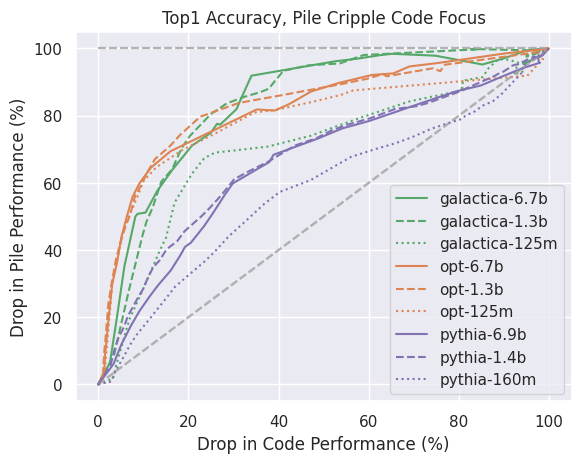

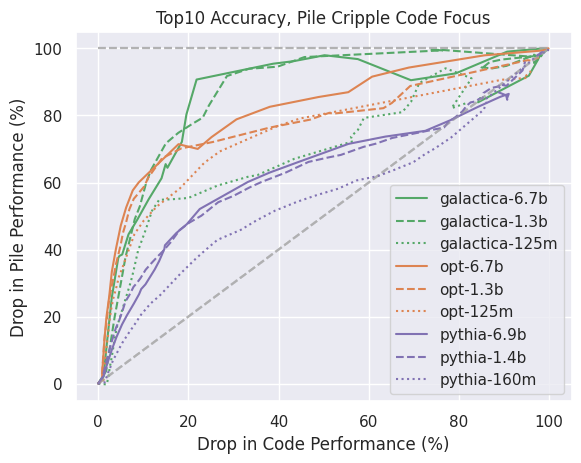

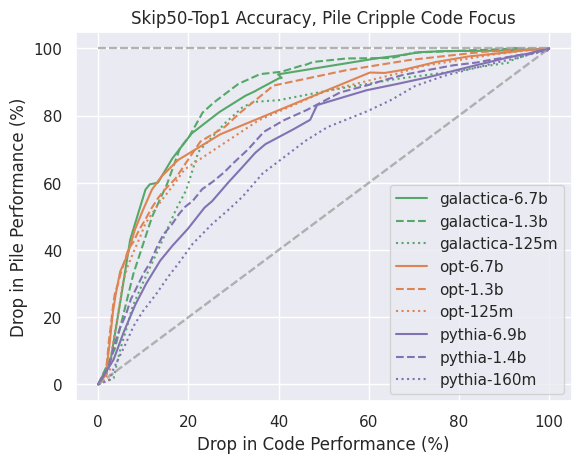

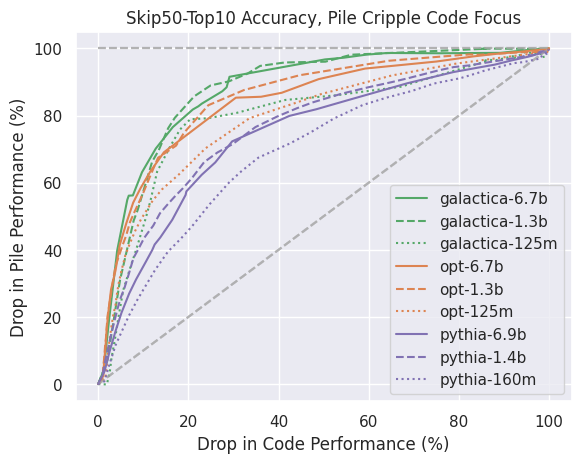

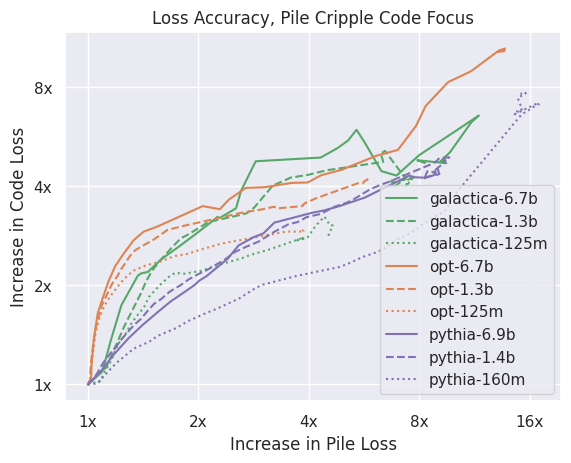

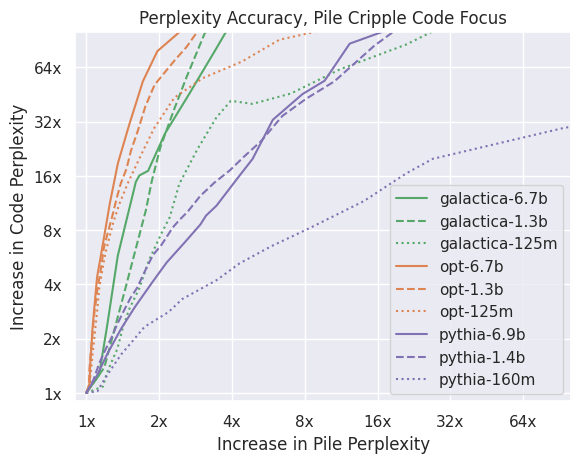

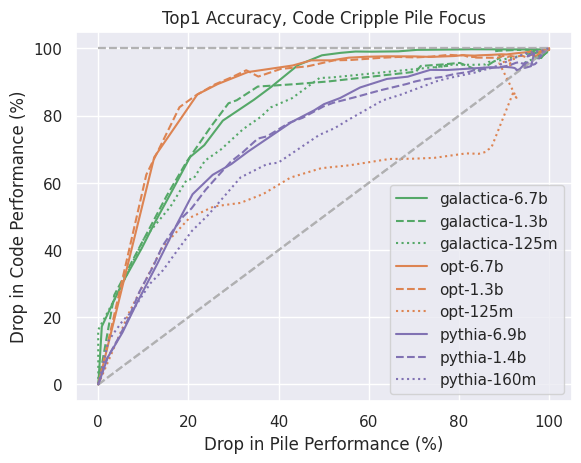

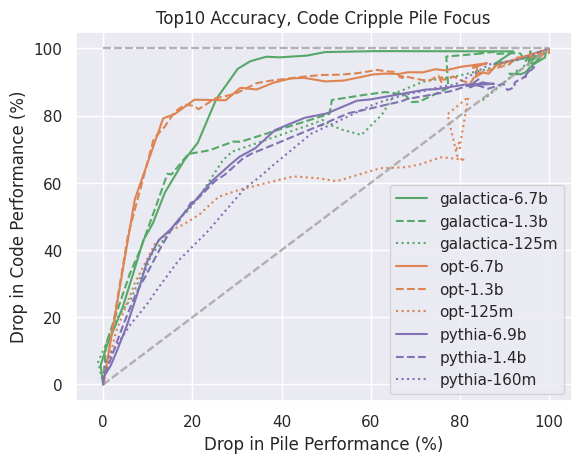

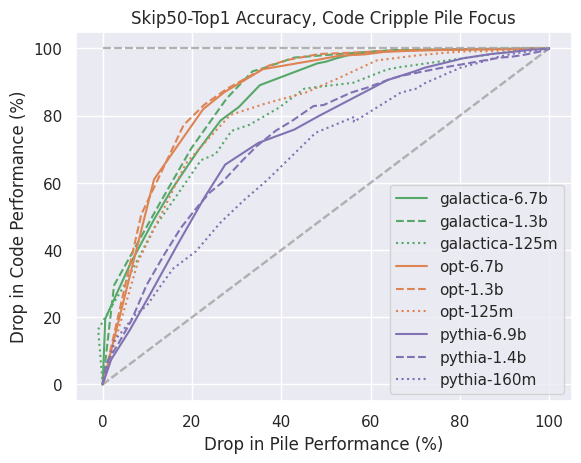

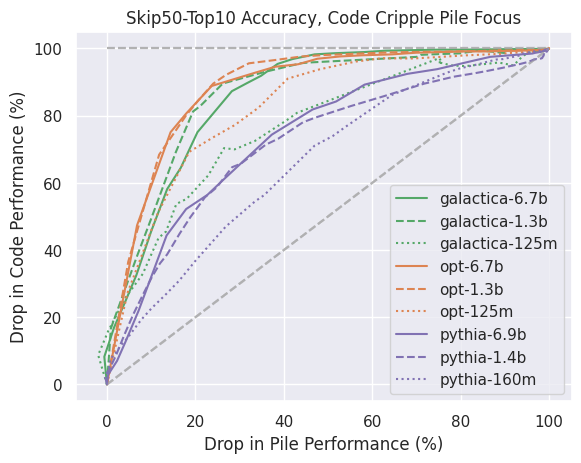

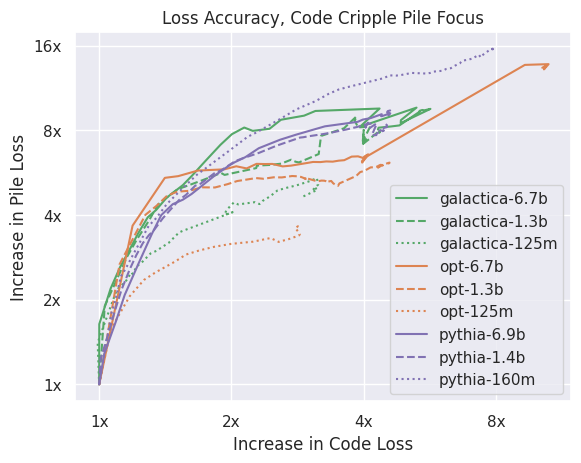

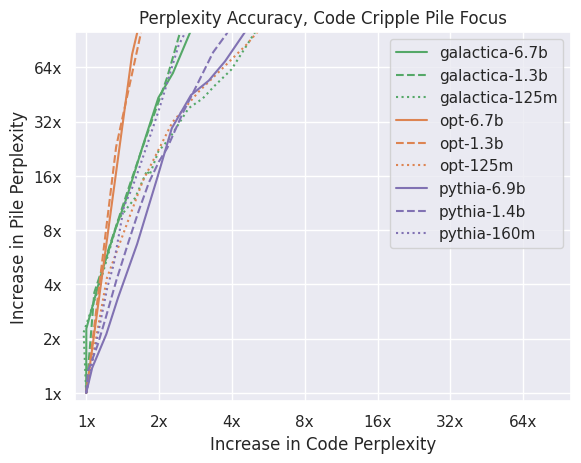

In [5]:
runs_filtered = filter_crashed_runs(_runs_pile_code, run_limit=None)
plot_best_metrics(runs_filtered, False) 

                      name  Top1  Top10  Skip50-Top1  Skip50-Top10
0   gal 6.7b ff py cripple 0.161  0.170        0.231         0.261
1   gal 1.3b ff py cripple 0.214  0.171        0.274         0.335
2   gal 125m ff py cripple 0.058 -0.011        0.145         0.137
3   opt 6.7b ff py cripple 0.228  0.171        0.288         0.349
4   opt 1.3b ff py cripple 0.167  0.151        0.223         0.319
5   opt 125m ff py cripple 0.007  0.010        0.176         0.183
6     gal 6.7b ff py focus 0.285  0.346        0.232         0.290
7     gal 1.3b ff py focus 0.256  0.256        0.219         0.266
8     gal 125m ff py focus 0.119  0.100        0.056         0.038
9     opt 6.7b ff py focus 0.235  0.221        0.293         0.274
10    opt 1.3b ff py focus 0.171  0.153        0.214         0.163
11    opt 125m ff py focus 0.108  0.094        0.097         0.029


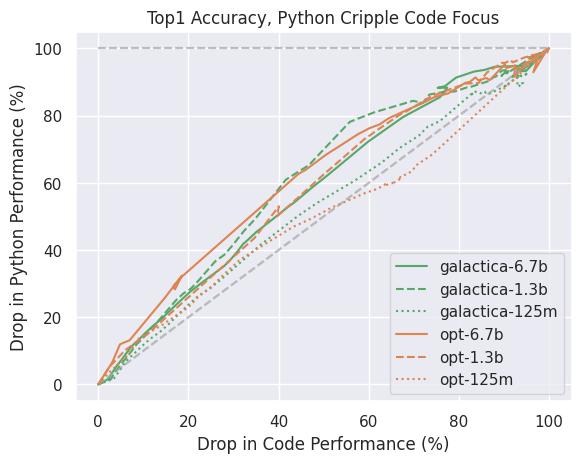

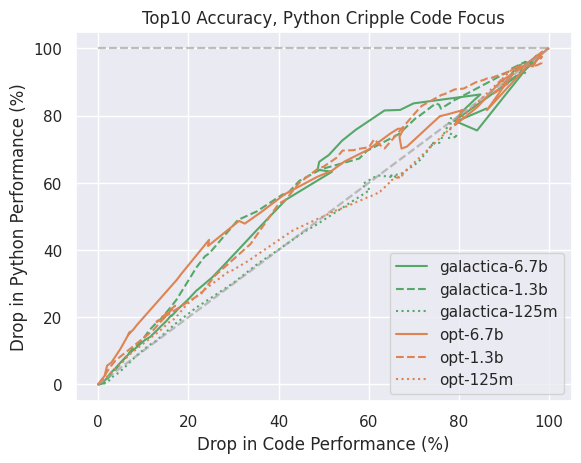

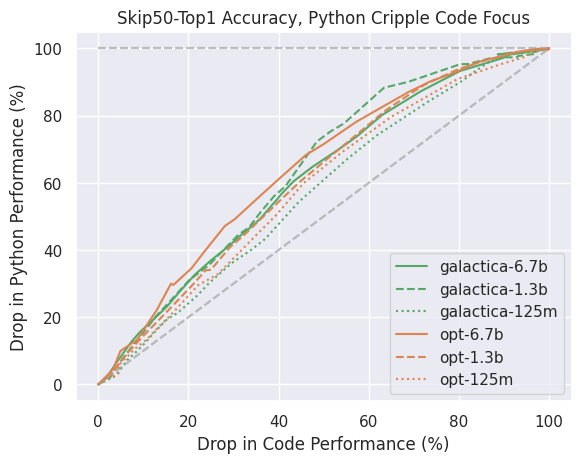

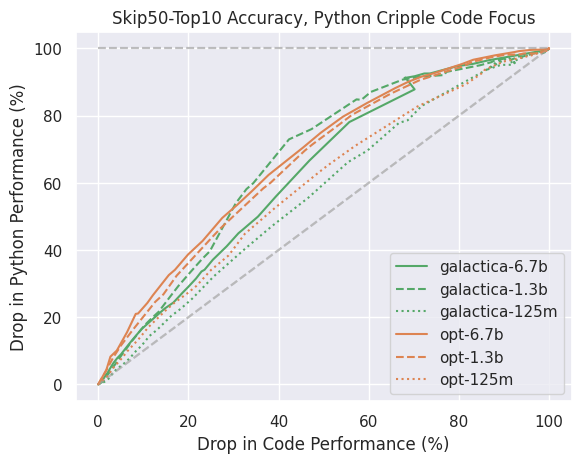

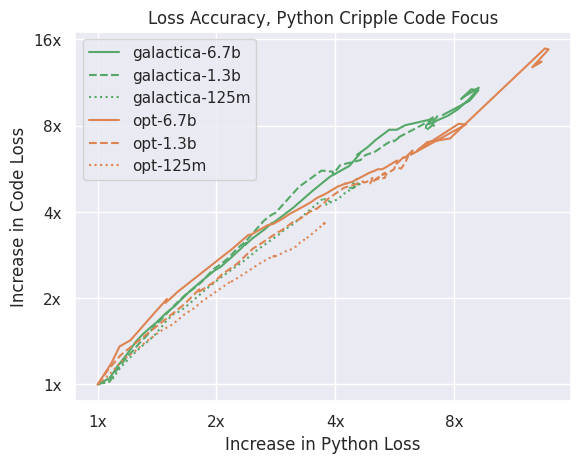

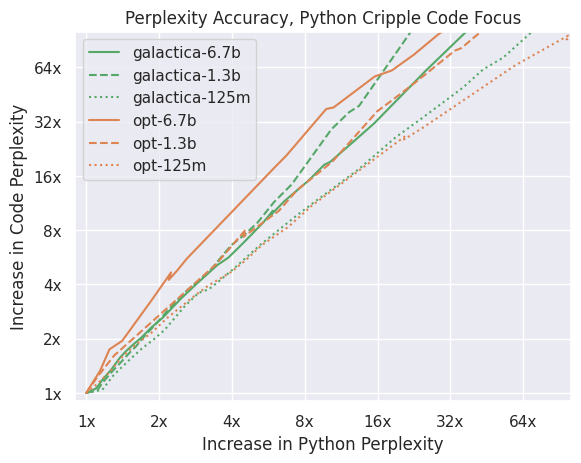

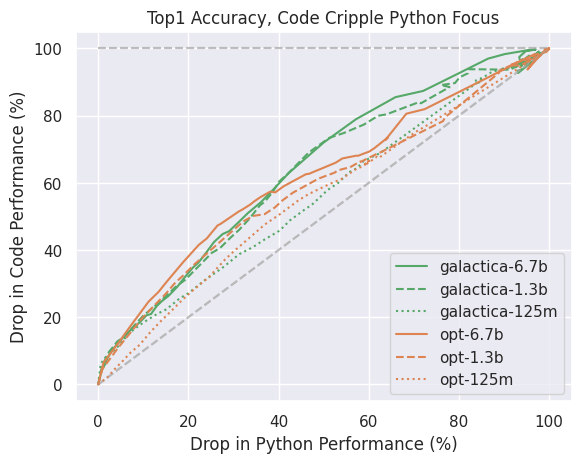

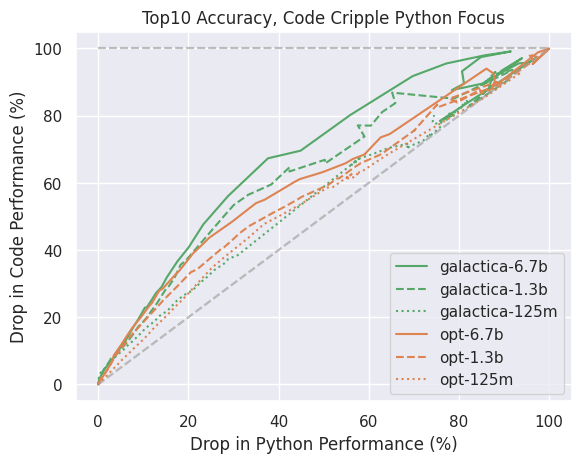

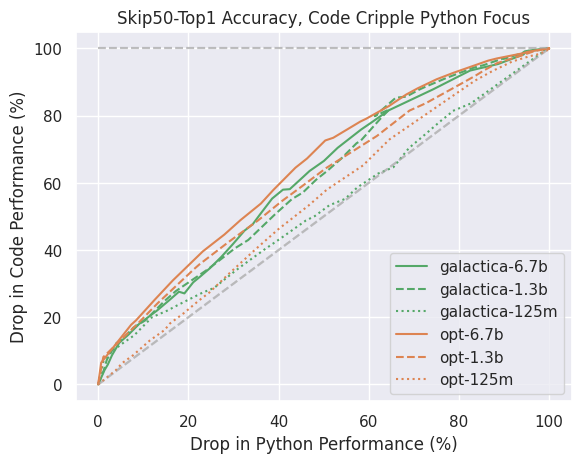

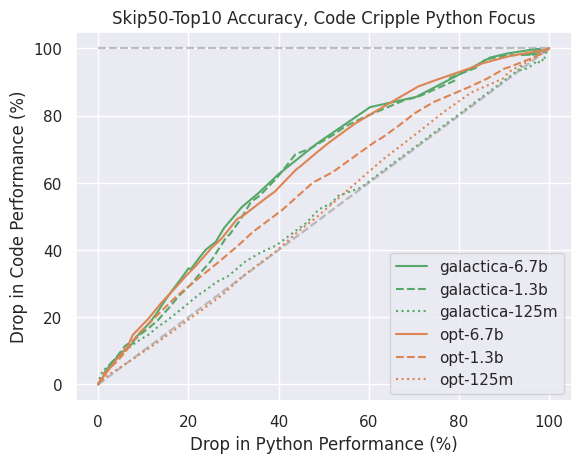

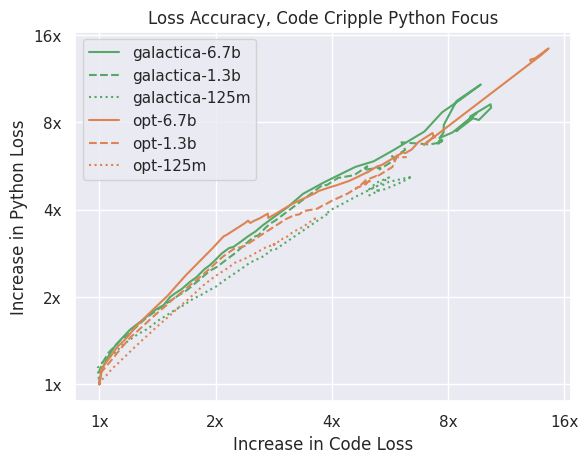

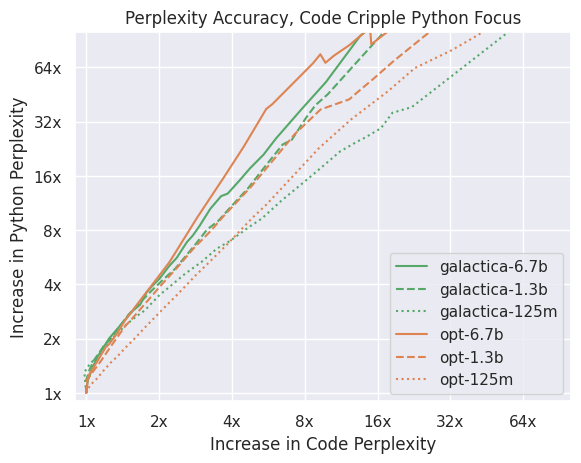

In [6]:
runs_filtered = filter_crashed_runs(_runs_code_python, run_limit=None)
plot_best_metrics(runs_filtered, False) 